Загрузим нужные библиотеки

In [1]:
! python -m spacy download ru_core_news_sm

                                              0.0/15.3 MB ? eta -:--:--
                                              0.0/15.3 MB 1.3 MB/s eta 0:00:12
                                              0.1/15.3 MB 1.1 MB/s eta 0:00:14
                                              0.1/15.3 MB 1.0 MB/s eta 0:00:15
                                              0.2/15.3 MB 1.2 MB/s eta 0:00:13
                                              0.3/15.3 MB 1.3 MB/s eta 0:00:12
                                              0.3/15.3 MB 1.5 MB/s eta 0:00:10
     -                                        0.5/15.3 MB 1.7 MB/s eta 0:00:09
     -                                        0.6/15.3 MB 1.8 MB/s eta 0:00:09
     -                                        0.7/15.3 MB 1.9 MB/s eta 0:00:08
     -                                        0.7/15.3 MB 1.9 MB/s eta 0:00:08
     --                                       0.8/15.3 MB 2.0 MB/s eta 0:00:08
     --                                       0.9/15.3 MB 2

In [2]:
import pandas as pd
import unicodedata
import re
import spacy
import json
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import json
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

# Подготовка данных

Загрузим данные

In [3]:
data = pd.read_csv('csv\\full_df.csv', sep=';')
data.head(3)
data = data.drop(columns='Unnamed: 0', axis=1)

Отфильтруем тексты по количеству символов. Оставим только 100+.

In [4]:
data['text_len'] = data.loc[:, 'text'].apply(lambda x: len(x))
data_filtered_by_text_len = data.query('text_len > 100')
print(f'Количество постов с 100+ символами: {data_filtered_by_text_len.shape[0]}')
data_filtered_by_text_len.head(3)

Количество постов с 100+ символами: 8556


,status,url,text,likes,reposts,comments,text_len
0,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,Всем привет!Выпустил свою первую статью на хаб...,17.0,0.0,0.0,295
1,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,"Если вам интересно позалипать в слова, я запус...",6.0,0.0,2.0,117
2,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,"Если вам интересно позалипать в слова, я запус...",17.0,6.0,0.0,117


Оставим только тексты содержащие кириллицу

In [5]:
data_cyrillic = data_filtered_by_text_len[data_filtered_by_text_len['text'].apply(lambda x: re.match(r'[А-Яа-я]+', x) is not None)]

print(f'Текстов на кириллице: {data_cyrillic.shape[0]}')
data_cyrillic.head(3)

Текстов на кириллице: 1960


,status,url,text,likes,reposts,comments,text_len
0,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,Всем привет!Выпустил свою первую статью на хаб...,17.0,0.0,0.0,295
1,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,"Если вам интересно позалипать в слова, я запус...",6.0,0.0,2.0,117
2,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,"Если вам интересно позалипать в слова, я запус...",17.0,6.0,0.0,117


Удалим дубликаты текстов

In [6]:
data_dd = data_cyrillic.drop_duplicates('text')
print(f'Осталось {data_dd.shape[0]} строк')
data_dd.head(3)

Осталось 1862 строк


,status,url,text,likes,reposts,comments,text_len
0,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,Всем привет!Выпустил свою первую статью на хаб...,17.0,0.0,0.0,295
1,Middle Software Engineer - Yandex,https://www.linkedin.com/in/michilegorov,"Если вам интересно позалипать в слова, я запус...",6.0,0.0,2.0,117
6,Talent Acquisition Manager | Recruitment Lead ...,https://www.linkedin.com/in/dariaivanova,С трепетом готов представить свой продукт. Реф...,8.0,0.0,0.0,841


# Подготовка к моделированию

In [7]:
texts = data_dd["text"].tolist()
texts[0]

'Всем привет!Выпустил свою первую статью на хабр!https://lnkd.in/dt9N6D7BСтатья про историю и технологии разработки игры https://guess-word.com и как мы создали игру с элементами машинного обучения и вышли в ноль за 2 месяцаПри\xa0внимательном прочтении вы даже сможете запустить первую версию игры!'

Проведем лемматизацию

In [8]:
if os.path.exists('lemmas.json'):
    with open("lemmas.json") as f:
        data_lemmatized = json.load(f)['lemmas']
else:
    model = spacy.load('ru_core_news_sm', disable=['ner', 'parser'])
    data_lemmatized = []
    for doc in model.pipe(texts, disable=["tagger", "parser"]):
        data_lemmatized.append([token.lemma_ for token in doc])

    with open("lemmas.json", "w") as fid:
        json.dump({"lemmas": data_lemmatized}, fid)

print(data_lemmatized[0])

['всем', 'привет!выпустил', 'свой', 'первый', 'статья', 'на', 'хабр!https://lnkd.in', '/', 'dt9n6d7bстатья', 'про', 'история', 'и', 'технология', 'разработка', 'игра', 'https://guess-word.com', 'и', 'как', 'мы', 'создать', 'игра', 'с', 'элемент', 'машинный', 'обучение', 'и', 'выйти', 'в', 'ноль', 'за', '2', 'месяцапри', '\xa0', 'внимательный', 'прочтение', 'вы', 'даже', 'смочь', 'запустить', 'первый', 'версия', 'игра', '!']


Очистим тексты от ненужных символов

In [9]:
word_pattern = re.compile("^[а-я]*$")

def remove_symbols(doc):
    return [token for token in doc if word_pattern.match(token)]

data_words = list(map(remove_symbols, data_lemmatized))
print(data_words[0])

['всем', 'свой', 'первый', 'статья', 'на', 'про', 'история', 'и', 'технология', 'разработка', 'игра', 'и', 'как', 'мы', 'создать', 'игра', 'с', 'элемент', 'машинный', 'обучение', 'и', 'выйти', 'в', 'ноль', 'за', 'месяцапри', 'внимательный', 'прочтение', 'вы', 'даже', 'смочь', 'запустить', 'первый', 'версия', 'игра']


Загрузим русские стоп-слова

In [10]:
stop_words = stopwords.words('russian')
stop_words += ['это', 'свой', 'очень', 'мочь', 'ваш', 'наш']

Определим функцию для удаления стоп-слов

In [11]:
def remove_stopwords(texts):
    return [[word for word in doc if word not in stop_words] for doc in texts]

Применим функцию для удаления стоп-слов

In [12]:
data_words_nostops = remove_stopwords(data_words)

In [13]:
id2word = corpora.Dictionary(data_words_nostops)

texts = data_words_nostops

corpus = [id2word.doc2bow(text) for text in texts]

In [14]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('версия', 1),
  ('внимательный', 1),
  ('всем', 1),
  ('выйти', 1),
  ('запустить', 1),
  ('игра', 3),
  ('история', 1),
  ('машинный', 1),
  ('месяцапри', 1),
  ('ноль', 1),
  ('обучение', 1),
  ('первый', 2),
  ('прочтение', 1),
  ('разработка', 1),
  ('смочь', 1),
  ('создать', 1),
  ('статья', 1),
  ('технология', 1),
  ('элемент', 1)]]

# Протестируем моделирование с 20 темами

In [15]:
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=20, 
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
    )

In [16]:
lda_model.print_topics()

[(0,
  '0.131*"язык" + 0.073*"английский" + 0.029*"требование" + 0.025*"казахстан" + 0.023*"психология" + 0.016*"отклик" + 0.014*"аренда" + 0.012*"среда" + 0.011*"называть" + 0.008*"представитель"'),
 (1,
  '0.114*"навык" + 0.054*"тест" + 0.047*"профиль" + 0.044*"проверка" + 0.027*"стратегия" + 0.025*"значок" + 0.023*"айти" + 0.023*"коммуникация" + 0.022*"топ" + 0.016*"фронтенд"'),
 (2,
  '0.052*"пожалуйста" + 0.029*"метод" + 0.029*"которыми" + 0.015*"доставка" + 0.015*"начаться" + 0.012*"выразить" + 0.012*"познакомиться" + 0.011*"александр" + 0.011*"замечательный" + 0.011*"благодарность"'),
 (3,
  '0.037*"давно" + 0.035*"яндекс" + 0.023*"счастливый" + 0.020*"стажировка" + 0.020*"перейти" + 0.019*"нем" + 0.019*"защита" + 0.018*"ними" + 0.016*"недвижимость" + 0.015*"живой"'),
 (4,
  '0.075*"пост" + 0.037*"час" + 0.036*"рынок" + 0.030*"некоторый" + 0.025*"ответ" + 0.024*"пара" + 0.021*"формат" + 0.021*"период" + 0.021*"получиться" + 0.020*"которых"'),
 (5,
  '0.077*"иб" + 0.033*"сообщест

Вычислим сложность и согласованность модели

In [17]:
print('Perplexity: ', lda_model.log_perplexity(corpus))

coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -16.32591711948903
Coherence Score:  0.44153426954519304


Отобразим результаты моделирования

In [18]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13    -0.412616  0.211949       1        1  39.488429
18    -0.386007 -0.009909       2        1  26.901117
9     -0.163284 -0.344627       3        1   9.639069
17    -0.050919 -0.134688       4        1   4.953246
4     -0.028931 -0.006579       5        1   4.578087
10     0.007584  0.005933       6        1   3.234714
19     0.060226  0.020879       7        1   1.616924
15     0.062884  0.021014       8        1   1.457690
1      0.059363  0.028080       9        1   1.051869
6      0.073070  0.020534      10        1   0.973949
5      0.073717  0.020529      11        1   0.892832
0      0.073526  0.020487      12        1   0.889823
8      0.070322  0.022778      13        1   0.809743
16     0.072076  0.016843      14        1   0.807119
3      0.078881  0.019570      15        1   0.738787
14     0.079109  0.019399      16        1   0.717803
2      0.081931  0.018278      17        1   0.499330
12     0.081330  0.018534      18        1   0.422187
7      0.083398  0.017065      19        1   0.308366
11     0.084340  0.013931      20        1   0.018915, topic_info=                Term         Freq        Total Category  logprob  loglift
236           работа  1941.000000  1941.000000  Default  30.0000  30.0000
46          компания  1096.000000  1096.000000  Default  29.0000  29.0000
1564            пост   347.000000   347.000000  Default  28.0000  28.0000
327             курс   318.000000   318.000000  Default  27.0000  27.0000
193           проект   794.000000   794.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
25       благодарный     0.001266   136.304340  Topic20  -9.6284  -3.0137
26              весь     0.001266  1166.959236  Topic20  -9.6284  -5.1609
27             взять     0.001266    83.724244  Topic20  -9.6284  -2.5263
28           внешний     0.001266    32.442886  Topic20  -9.6284  -1.5783
29    вознаграждение     0.001266     2.830684  Topic20  -9.6284   0.8607

[791 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1559      8  0.833379     автомобиль
1068      7  0.977151          автор
220       6  0.981008      агентство
1575     12  0.810684      адаптация
1364      9  0.842056     адаптивный
...     ...       ...            ...
1630     15  0.635379           этаж
833       8  0.989227           этап
1545     10  0.946332  эффективность
219      12  0.990636           язык
272      15  0.961507         яндекс

[571 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 19, 10, 18, 5, 11, 20, 16, 2, 7, 6, 1, 9, 17, 4, 15, 3, 13, 8, 12])

# Подбор количества тем

Подберем количество тем основываясь на согласованности модели

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=id2word,
            num_topics=num_topics, 
            random_state=765,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            per_word_topics=True
            )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [20]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_nostops, start=1, limit=10, step=1)

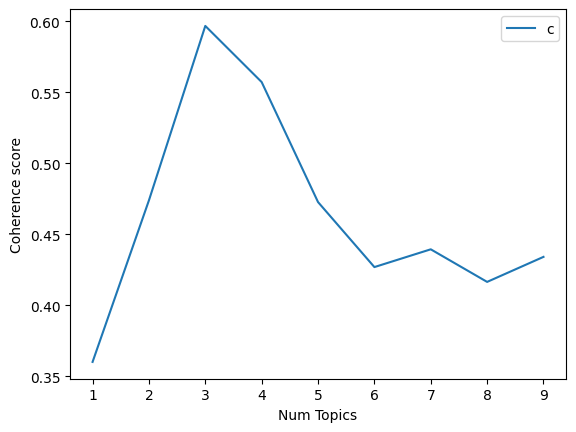

In [21]:
limit=10
start=1
step=1
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Наилучший результат показала модель с 3 темами

In [22]:
def model_scorer(data):
    id2word = corpora.Dictionary(data)

    texts = data

    corpus = [id2word.doc2bow(text) for text in texts]

    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=3, 
        random_state=765,
        update_every=1,
        chunksize=100,
        passes=10,
        alpha='auto',
        per_word_topics=True
        )

    print('Perplexity: ', lda_model.log_perplexity(corpus))

    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('Coherence Score: ', coherence_lda)

    return lda_model, corpus, id2word

best_model, best_corpus, best_id2word = model_scorer(data_words_nostops)

Perplexity:  -8.381390061581836
Coherence Score:  0.5966520391095856


# Использование биграмм и триграмм

Проверим, повлияет ли использование биграмм и триграмм на согласованность модели

In [23]:
bigram = gensim.models.Phrases(data_words_nostops, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words_nostops], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [24]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

data_words_bigrams = make_bigrams(data_words_nostops)
data_words_trigrams = make_trigrams(data_words_nostops)

In [25]:
model_scorer(data_words_bigrams)
print('Complete')

Perplexity:  -8.434334494421696
Coherence Score:  0.439582008213859
Complete


In [26]:
model_scorer(data_words_trigrams)
print('Complete')

Perplexity:  -8.429958224926464
Coherence Score:  0.5836013461964166
Complete


Использование биграмм и триграмм только ухудшили согласованнось

# Анализ наилучшей модели

In [27]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, best_corpus, best_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.163100  0.125427       1        1  54.146368
2     -0.063423 -0.168545       2        1  40.627477
1      0.226523  0.043119       3        1   5.226155, topic_info=          Term        Freq       Total Category  logprob  loglift
46    компания  629.000000  629.000000  Default  30.0000  30.0000
87     человек  568.000000  568.000000  Default  29.0000  29.0000
7842         з   92.000000   92.000000  Default  28.0000  28.0000
193     проект  453.000000  453.000000  Default  27.0000  27.0000
45     команда  375.000000  375.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
8667    багато    8.966265    9.593106   Topic3  -6.3846   2.8839
9910     зараз    9.056113    9.689467   Topic3  -6.3747   2.8839
902        час   19.442024   93.664742   Topic3  -5.6107   1.3792
97        день   14.133790  241.625384   Topic3  -5.9295   0.1127
413      робот    9.912367   30.353676   Topic3  -6.2843   1.8324

[182 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
7841      3  0.958037       або
8500      3  0.955864       але
454       1  0.996770    анализ
690       1  0.999779  аналитик
8667      3  0.938174    багато
...     ...       ...       ...
8649      3  0.990614        що
8650      3  0.987770       щоб
8530      3  0.988441        як
8867      3  0.941401      який
8532      3  0.962928      якщо

[203 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [28]:
topic_probs = best_model.get_document_topics(best_corpus)
max_prob_topics = list(map(lambda doc_probs: max(doc_probs, key=lambda x: x[1])[0], topic_probs))

In [29]:
df = pd.DataFrame([list(data_dd["text"]), max_prob_topics]).transpose()
df.columns = ['text', 'topic_label']
df.head(3)

,text,topic_label
0,Всем привет!Выпустил свою первую статью на хаб...,0
1,"Если вам интересно позалипать в слова, я запус...",2
2,С трепетом готов представить свой продукт. Реф...,0


In [35]:
df.loc[df['topic_label'] == 1].head()

,text,topic_label
159,"Юрий Бура (@juriy), спасибо! Это были очень кр...",1
306,"Штош, надоело мне в IT. Уволюсь и открою пивну...",1
336,Компания первой создавший и распространивший э...,1
607,Дизайн и верстка. Земельные участки Подмосковь...,1
609,Лендинг пейдж для службы вскрытия дверей. #web...,1


In [38]:
best_model.show_topic(2)

[('человек', 0.012023695),
 ('весь', 0.007881439),
 ('время', 0.0067690583),
 ('год', 0.0065009254),
 ('нужный', 0.0050492613),
 ('делать', 0.004994253),
 ('жизнь', 0.0047352044),
 ('день', 0.004474903),
 ('работа', 0.0042895307),
 ('работать', 0.00423403)]

# Вывод

С имеющимися данными наилучшую согласованность имеет модель с разделением на 3 темы. После разделения на 3 темы было выявлено, что как отдельная тема выделены тексты на украинском языке. Для получения нормальных результатов нужно провести повторное моделирование исключив из данных украинские тексты.